## SoH000 - A comparative study of different features extracted from EIS in SoH

### Estimaion of Process list
1. [1. Data_Preprocessing](#Data_Preprocessing)
2. [2. Check the Correlation between Features(EIS) and Target(SoH)](#2_Check_the_Correlation_between_Features(EIS)_and_Target(SoH))
3. [3. GPR(Gaussian Processing Regression) of Machine Learning ](#3_GPR(Gaussian_Processing_Regression)_of_Machine_Learning )

### 1_Data_Preprocess

#### 1. Import Libaray

In [1]:
# import library
import os
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Graph Font setting
def setGraphFont():
    import matplotlib.font_manager as fm

    # import set fonts
    font_list = [font.name for font in fm.fontManager.ttflist]

    # set default font
    plt.rcParams['font.family'] = font_list[np.min([i for i in range(len(font_list)) if 'Times New Roman' in font_list[i]])]  # -12 : Times New Roman, -14 : Nanum gothic
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['lines.linewidth'] = 1.5
    plt.rc("axes", unicode_minus=False)

    # Configure rcParams axes.prop_cycle to simultaneously cycle cases and colors.
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)
setGraphFont()

#### 2. Capacity raw data preprocessing according to cycle

In [3]:
# Set Capacity Raw data path
cap_path = "C:/Users/jeongbs1/오토실리콘/1. python_code/Practice_with_paper_data_sets/A comparative study of different features extracted from EIS in SoH for LIB/raw_data(SDI)"

# Load Raw data
cap_df = pd.read_csv(cap_path+"./Cell1-cell4.txt", skiprows=2, sep='\t')

# Set Columns
cap_df_col = ["cycle_1_3", "Cell1_cap", "Cell1_dec", "Cell3_cap", "Cell3_dec", "cycle_2_4", "Cell2_cap", "Cell2_dec", "Cell4_cap", "Cell4_dec"]

# Apply colums to DataFrame
cap_df.columns = cap_df_col

# Data processing for SoH calculation for each cell
cap_df = cap_df.replace("--", np.nan).astype(float)

# SoH calculation per cell
for i in range(1,5):
    cap_column = f"Cell{i}_cap"
    soh_column = f"Cell{i}_SoH"
    cap_df[soh_column] = round((cap_df[cap_column].astype(float) / 2.75) * 100, 2)

# Set SoH Dataframe column
SoH_Colunms = ['cycle_1_3', 'Cell1_SoH', 'Cell3_SoH', 'cycle_2_4', 'Cell2_SoH', 'Cell4_SoH']

# Make SoH Dataframe
SoH_df = cap_df[SoH_Colunms]

SoH_df.head(10)

,cycle_1_3,Cell1_SoH,Cell3_SoH,cycle_2_4,Cell2_SoH,Cell4_SoH
0,0.0,96.35,95.85,0.0,96.69,96.54
1,25.0,95.80,94.35,100.0,95.40,93.84
2,50.0,95.31,94.78,200.0,95.01,93.87
3,75.0,94.29,94.09,300.0,94.65,94.26
4,100.0,93.34,93.25,400.0,94.47,93.61
5,125.0,92.64,92.18,500.0,94.05,93.01
6,150.0,92.04,91.25,600.0,93.75,93.71
7,175.0,91.75,91.16,700.0,93.31,92.84
8,200.0,91.03,90.69,800.0,93.71,92.51
9,225.0,90.24,89.32,900.0,93.75,91.96


In [4]:
# Data settings for merging with EIS data
def process_soh_df(df, cycle_col, soh_col, cell_name):
    # Make SoH DataFrame by Cell
    df = df[[cycle_col, soh_col]].dropna().copy()
    # Make cycle, SoH DataFrame by Cell
    df.columns = ["Cycle", "SoH"]
    # Separation for merging with eis dataframe by cell
    df["Cell_Name"] = cell_name
    return df

# Apply to individual cells
SoH_df_cell1 = process_soh_df(SoH_df, 'cycle_1_3', 'Cell1_SoH', "Cell_1")
SoH_df_cell2 = process_soh_df(SoH_df, 'cycle_2_4', 'Cell2_SoH', "Cell_2")
SoH_df_cell3 = process_soh_df(SoH_df, 'cycle_1_3', 'Cell3_SoH', "Cell_3")
SoH_df_cell4 = process_soh_df(SoH_df, 'cycle_2_4', 'Cell4_SoH', "Cell_4")

# relocation column order before merging
SoH_df_cell1 = SoH_df_cell1[["Cell_Name", "Cycle", "SoH"]]
SoH_df_cell2 = SoH_df_cell2[["Cell_Name", "Cycle", "SoH"]]
SoH_df_cell3 = SoH_df_cell3[["Cell_Name", "Cycle", "SoH"]]
SoH_df_cell4 = SoH_df_cell4[["Cell_Name", "Cycle", "SoH"]]

#### 3. EIS raw data preprocessing abbording to cycle

In [5]:
# Set Capacity Raw data path
eis_forder_cell_path = "C:/Users/jeongbs1/오토실리콘/1. python_code/Practice_with_paper_data_sets/A comparative study of different features extracted from EIS in SoH for LIB/raw_data(SDI)"
# Make folder list
eis_forder_cell_list = [forder for forder in os.listdir(eis_forder_cell_path) if os.path.isdir(os.path.join(eis_forder_cell_path, forder))]
# Make dictionary for each cell
eis_raw_df = {cell: {} for cell in ["Cell1", "Cell2", "Cell3", "Cell4"]}

In [6]:
# EIS raw data upload loop creation for each cell and cycle
for cell_name in eis_forder_cell_list:
    # Specify file path per cell
    cell_path = Path(eis_forder_cell_path) / cell_name
    # Cycle folder list append
    cycle_list = [cycle for cycle in os.listdir(cell_path) if "cycle" in cycle]
    # Load file with SoC 50% and temperature 25degree for each cycle
    for cycle_name in cycle_list:
        # Specify SoC 50% folder path
        cycle_path = cell_path / cycle_name / "50soc"
        # Temperature 25 degrees file search
        eis_file = next((file for file in os.listdir(cycle_path) if "25d" in file), None)
        # If the file exists, append it to the dataframe
        if eis_file:
            # Save cell information in dataframe with cycle_soc_temp
            df_name = str(cycle_name.split("cycle")[1])+"_"+str(re.findall(r'\d+',(eis_file.split('_')[1]))[0])+"_"+str(re.findall(r'\d+',(eis_file.split('_')[2]))[0])
            file_path = cycle_path / eis_file
            eis_raw_df[cell_name][df_name] = pd.read_csv(file_path, sep=r'\s+', header=None, names=["Frequency", "Real_Z", "Imaginary_Z"])

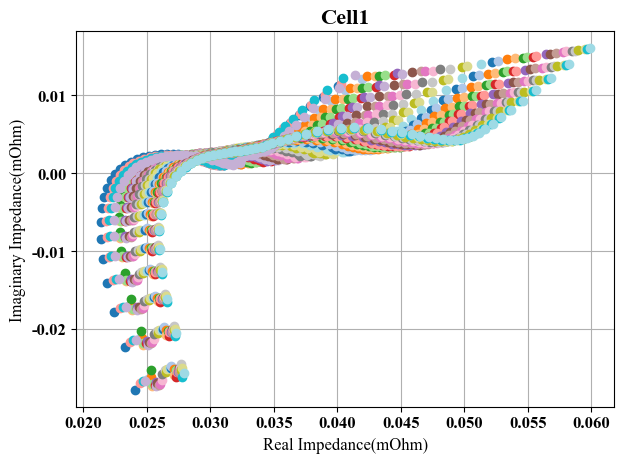

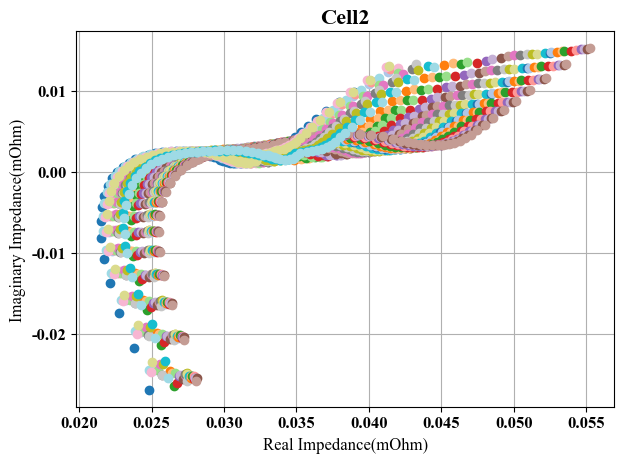

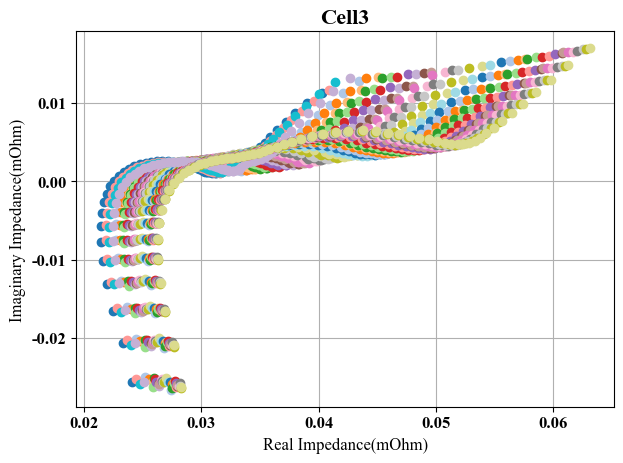

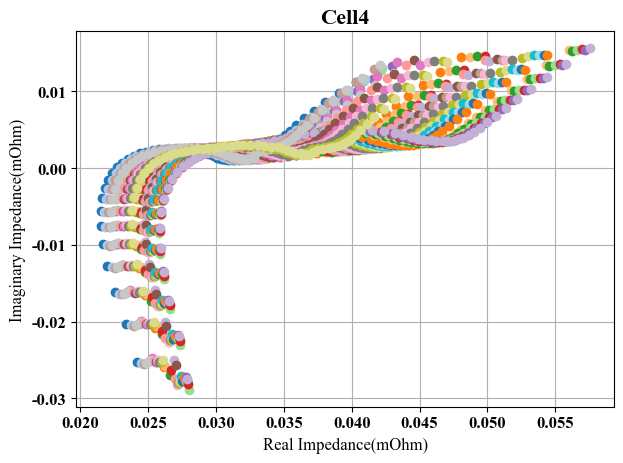

In [7]:
# make cell list
cell_num = list(eis_raw_df.keys())

for cell in cell_num:
    plt.figure()
    for num in eis_raw_df[cell]:
        plt.plot((eis_raw_df[cell][num]["Real_Z"]), -(eis_raw_df[cell][num]["Imaginary_Z"]), "o")
    plt.xlabel("Real Impedance(mOhm)")
    plt.ylabel("Imaginary Impedance(mOhm)")
    plt.title(cell, fontweight='bold', fontsize=16)
    plt.tight_layout()

In [8]:
# make data frame for each cell
stack_eis_row_df = {cell: pd.DataFrame() for cell in cell_num}
# A loop that transposes rows/columns for EIS files for each cycle within cells saved from EIS raw data and stacks them downwards into one file.
for cell in range(len(cell_num)):
    # make cell info list
    cell_info_num = list((eis_raw_df[cell_num[cell]].keys()))
    transformed_data = []
    # Cycle-by-cycle EIS value staking loop
    for cyc in range(len(cell_info_num)):
        df_dummy = eis_raw_df[cell_num[cell]][cell_info_num[cyc]]
        tran_f_col = {}
        # loop to convert values from individual rows into columns
        for i, row in df_dummy.iterrows():
            freq = f"{row['Frequency']:.2f}"  # 소수 둘째 자리까지 표현
            tran_f_col["Cycle"] = float(cell_info_num[cyc].split("_")[0])
            tran_f_col["SoC"] = int(cell_info_num[cyc].split("_")[1])
            tran_f_col["Temp"] = int(cell_info_num[cyc].split("_")[2])
            tran_f_col[f"F_{freq}_Re_Z"] = row['Real_Z']
            tran_f_col[f"F_{freq}_Im_Z"] = row['Imaginary_Z']
        # Save to data frame
        transformed_data.append(pd.DataFrame([tran_f_col]))
    stack_eis_row_df[cell_num[cell]] = pd.concat(transformed_data, axis=0, ignore_index=True)
    # Specify columns in cell info-real-imaginary order
    info_cols = [col for col in stack_eis_row_df[cell_num[cell]].columns if not 'Z' in col]
    real_cols = [col for col in stack_eis_row_df[cell_num[cell]].columns if '_Re_Z' in col]
    imaginary_cols = [col for col in stack_eis_row_df[cell_num[cell]].columns if '_Im_Z' in col]
    ordered_cols = info_cols + real_cols + imaginary_cols
    # Apply specified column order
    stack_eis_row_df[cell_num[cell]] = stack_eis_row_df[cell_num[cell]][ordered_cols]
    # Sort ascending by cycle
    stack_eis_row_df[cell_num[cell]].sort_values(by="Cycle", ascending=True, ignore_index=True, inplace=True)

In [9]:
# Merge SoH dataframe and eis dataframe by cell
merged_dfs = []
for i, soh_df in enumerate([SoH_df_cell1, SoH_df_cell2, SoH_df_cell3, SoH_df_cell4]):
    merged_dfs.append(pd.merge(soh_df, stack_eis_row_df[cell_num[i]], on="Cycle", how="inner"))

# Merge data frames by merged cells into one
merged_df = pd.concat(merged_dfs, ignore_index=True)
merged_df["Cycle"] = merged_df["Cycle"].astype(int)
# merged_df.to_excel("C:/Users/jeongbs1/Downloads/merge_df.xlsx", index=False)

'''Preprocessing Complete'''

'Preprocessing Complete'

### 2_Check_the_Correlation_between_Features(EIS)_and_Target(SoH)

In [10]:
numeric_df, corr_df = {}, {}
for num in range(len(merged_dfs)):
    numeric_df[num] = merged_dfs[num].drop(columns=["Cycle", "SoC", "Temp", "Cell_Name"], axis=1)
    corr_df[num] = (numeric_df[0].corr()["SoH"])
    corr_df[num] = corr_df[num][corr_df[num].abs() > 0.8]
    print(len(corr_df[num]))

115
115
115
115


### 3_GPR(Gaussian_Processing_Regression)_of_Machine_Learning 

#### 1. Import library and Define function for GPR

In [11]:
''' Scikit-learn method '''
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [12]:
# Separate by case
def separate_cases(df, cell_name):
    train_df = df[df['Cell_Name'] != cell_name].copy().reset_index(drop=True)
    test_df = df[df['Cell_Name'] == cell_name].copy().reset_index(drop=True)
    return train_df, test_df

In [13]:
# Define a function to calculate performance metrics
def calculate_performance_metrics(y_true, y_pred, y_std):
    max_absolute_error = np.max(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
    mean_absolute_error_perc = mean_absolute_error(y_true, y_pred) / np.mean(np.abs(y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(np.abs(y_true)) * 100
    lower_bound = y_pred - 1.96 * y_std
    upper_bound = y_pred + 1.96 * y_std
    coverage = np.mean((y_true >= lower_bound) & (y_true <= upper_bound)) * 100
    mean_std_dev = np.mean(y_std) / np.mean(np.abs(y_true)) * 100

    return {'Cell Name': f'Cell {i + 1}',
            'Maximum Absolute Error (%)': max_absolute_error,
            'Mean Absolute Error (%)': mean_absolute_error_perc,
            'Root Mean Square Error (%)': rmse,
            'Coverage Probability (%)': coverage,
            'Mean Standard Deviation (%)': mean_std_dev}

#### 2. Feature extracted from broadband EIS

In [14]:
# GPR model training and prediction function
def train_and_predict_gpr_Braodband(train_x, train_y, test_x):
    scaler = StandardScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    kernel = C(1.0, (1e-3, 1e4)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1)
    gpr.fit(train_x_scaled, train_y)
    y_pred, y_std = gpr.predict(test_x_scaled, return_std=True)
    return y_pred, y_std

In [15]:
# Create a data frame to apply to ML Model
Broadband_df = merged_df.copy()

# Create a data frame for each case by calling a function
Broadband_cases = {"train" : {}, "test" : {}}
for i in np.arange(1,5):
    train_df, test_df = separate_cases(Broadband_df, f'Cell_{i}')
    Broadband_cases["train"][f'case{i}_train_df'] = train_df
    Broadband_cases["test"][f'case{i}_test_df'] = test_df

# Separate train and test dataframes
B_train_list = list(Broadband_cases["train"].keys())
B_test_list = list(Broadband_cases["test"].keys())

In [16]:
# Define the list of input columns (excluding unnecessary columns)
B_input_drop_col = ["Cell_Name", "Cycle", "SoH", "SoC", "Temp"]

# Initialize the list to store performance indicators
B_performance_metrics = []

# Initialize individual lists to store prediction results
all_actuals, all_predictions, all_std_devs = [], [], []

# Perform model training and prediction repeatedly for each dataset
for i in range(len(B_train_list)):
    # Define training and test data for each dataset
    train_x_raw = Broadband_cases["train"][B_train_list[i]].drop(columns=B_input_drop_col).values
    train_y_raw = Broadband_cases["train"][B_train_list[i]]["SoH"].values
    test_x_raw = Broadband_cases["test"][B_test_list[i]].drop(columns=B_input_drop_col).values
    test_y_raw = Broadband_cases["test"][B_test_list[i]]["SoH"].values

    # GPR model training and prediction
    y_pred, y_std = train_and_predict_gpr_Braodband(train_x_raw, train_y_raw, test_x_raw)

    # Calculate performance indicators and add to list
    metrics = calculate_performance_metrics(test_y_raw, y_pred, y_std)
    B_performance_metrics.append(metrics)

    
    # Add prediction results to individual list
    all_actuals.append(list(test_y_raw))  # 실제 값
    all_predictions.append(list(y_pred))  # 예측 값
    all_std_devs.append(list(y_std))  # 예측 표준편차

# Convert performance metrics to DataFrame
B_performance_df = pd.DataFrame(B_performance_metrics)

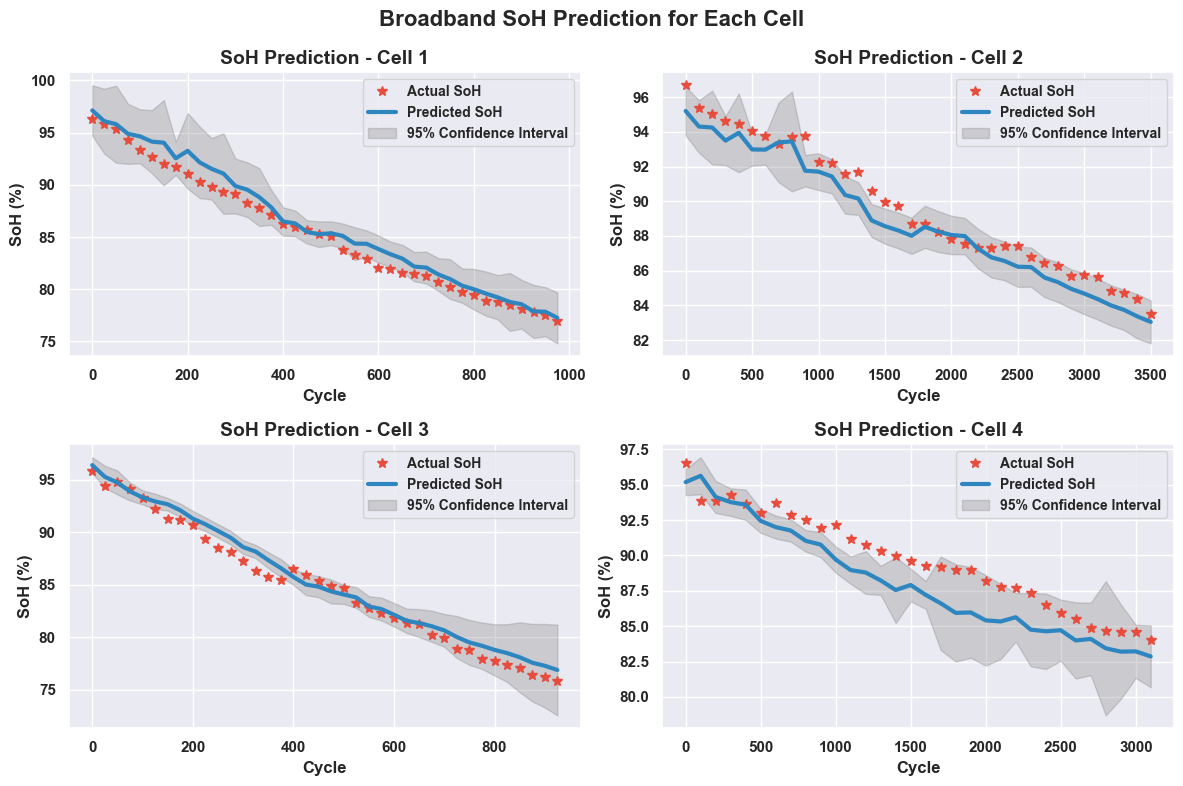

In [17]:
# Seaborn style settings
sns.set(style="darkgrid")

# Define a color list (use consistent colors for each data element)
colors = sns.color_palette("Spectral", 3)
actual_color = '#E74C3C'       
predicted_color = '#2E86C1'     
confidence_color = '#808080'    

# Calculate Cycle, Actual SoH, Predicted SoH, and confidence intervals
plt.figure(figsize=(12, 8))
for n in range(len(B_train_list)):
    plt.subplot(2, 2, n + 1)
    x = Broadband_cases["test"][B_test_list[n]]["Cycle"].values
    actual_soh = Broadband_cases["test"][B_test_list[n]]["SoH"].values
    predicted_soh = all_predictions[n]
    std_dev = all_std_devs[n]

    # Calculate 95% confidence interval
    lower_bound = np.array(predicted_soh) - 1.96 * np.array(std_dev)
    upper_bound = np.array(predicted_soh) + 1.96 * np.array(std_dev)

    # Draw a graph
    plt.plot(x, actual_soh, '*', color=actual_color, markersize=7, label='Actual SoH')  # 실제값 색상
    plt.plot(x, predicted_soh, '-', color=predicted_color, linewidth=3, label='Predicted SoH')  # 예측값 색상
    plt.fill_between(x, lower_bound, upper_bound, color=confidence_color, alpha=0.3, label='95% Confidence Interval')  # 신뢰 구간 색상

    # Add title and settings to each subplot
    plt.xlabel("Cycle", fontsize=12, fontweight='bold')
    plt.ylabel("SoH (%)", fontsize=12, fontweight='bold')
    plt.title(f"SoH Prediction - Cell {n+1}", fontsize=14, fontweight='bold')
    plt.legend(loc="upper right", fontsize="small")

# Set overall layout and title
plt.suptitle("Broadband SoH Prediction for Each Cell", fontsize=16, fontweight='bold')
plt.tight_layout()

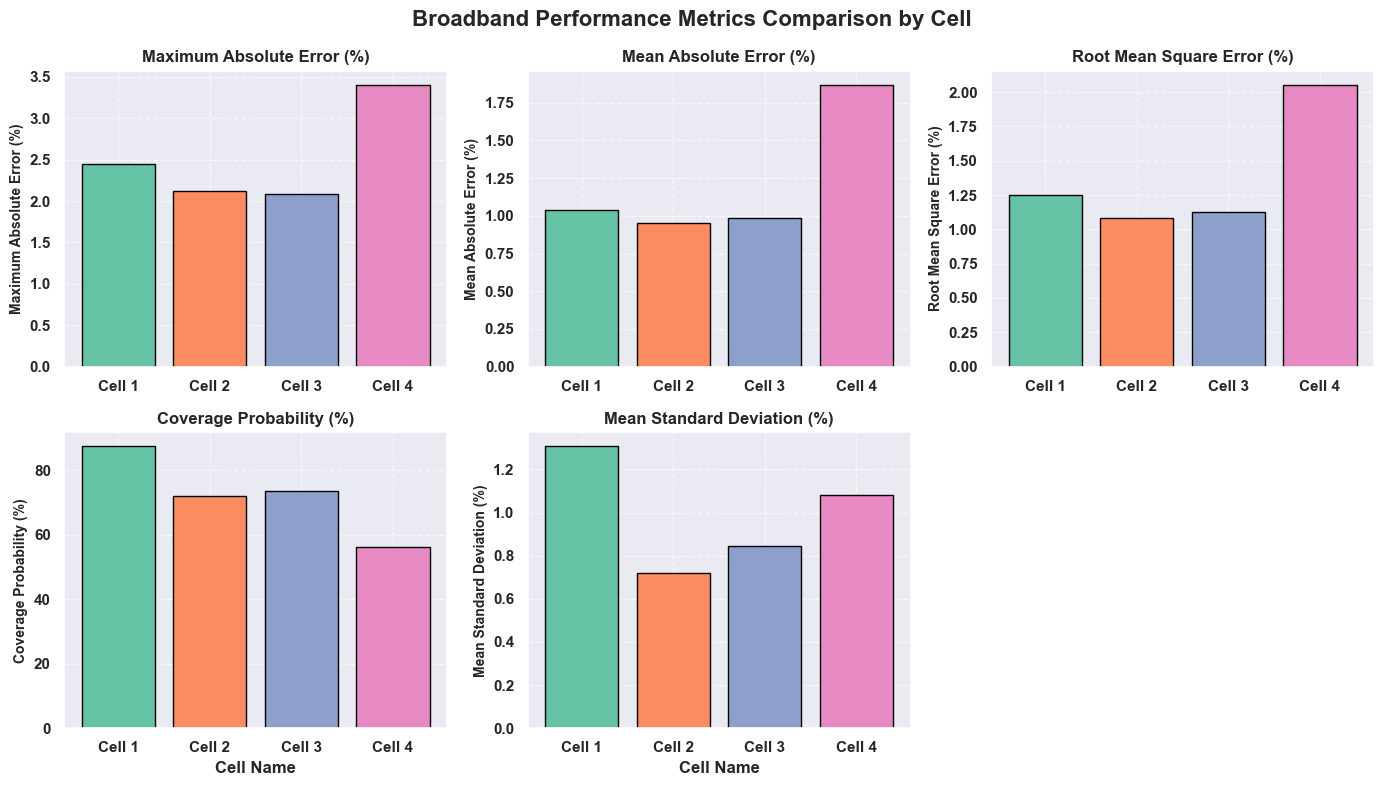

In [ ]:
# List of performance indicators
metrics = ["Maximum Absolute Error (%)", "Mean Absolute Error (%)",
           "Root Mean Square Error (%)", "Coverage Probability (%)",
           "Mean Standard Deviation (%)"]

# Define colors for each case using the Seaborn palette
colors = sns.color_palette("Set2", len(B_performance_df["Cell Name"]))

# Create a 2x3 subplot (including one empty spot)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Draw a bar graph for each performance indicator
for i, metric in enumerate(metrics):
    row, col = divmod(i, 3)  
    # Create a bar graph with the same color for each Case
    axes[row, col].bar(B_performance_df["Cell Name"], B_performance_df[metric], color=colors, edgecolor='black')
    axes[row, col].set_title(metric, fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric, fontsize=10, fontweight='bold')
    axes[row, col].grid(True, linestyle='--', alpha=0.7)

# Hide empty subplots
axes[1, 2].axis("off")

# Set X-axis label
for ax in axes[1, :2]:  # 마지막 행의 첫 두 축에만 x축 레이블 추가
    ax.set_xlabel("Cell Name", fontsize=12, fontweight='bold')

# Set overall layout
plt.suptitle("Broadband Performance Metrics Comparison by Cell", fontsize=16, fontweight='bold')
plt.tight_layout()